<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MtrD-amino-acid-characterization" data-toc-modified-id="MtrD-amino-acid-characterization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MtrD amino acid characterization</a></span><ul class="toc-item"><li><span><a href="#BLAST" data-toc-modified-id="BLAST-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>BLAST</a></span></li><li><span><a href="#Alignment" data-toc-modified-id="Alignment-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Alignment</a></span></li><li><span><a href="#Amino-acid-characterization" data-toc-modified-id="Amino-acid-characterization-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Amino acid characterization</a></span></li><li><span><a href="#Association-with-MIC" data-toc-modified-id="Association-with-MIC-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Association with MIC</a></span></li><li><span><a href="#Violin-plot" data-toc-modified-id="Violin-plot-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Violin plot</a></span></li><li><span><a href="#Other-resistance-genes" data-toc-modified-id="Other-resistance-genes-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Other resistance genes</a></span></li></ul></li></ul></div>

## MtrD amino acid characterization
We've included analysis code used to replicate the results and all figures for X et al., 2020 ("X"). Please reach out with any questions to kevinchenma@g.harvard.edu and we'll be happy to assist.

### BLAST

We use BLAST to pull out the mtrD sequences from the contigs using the FA1090 sequence as a reference. Then we apply several filters, including screening out mtrD sequences with lower than 99% nucleotide identity to focus our analyses on SNP mutations, and removing strains with predicted LOF mutations. The result is an amino acid alignment.

In [30]:
import pandas as pd
from Bio.Seq import Seq
import os

def blast_gene(gene):
    
    cmd = "blastn -db blast/2019-08-26_combined-contigs.fna -query blast/results/{0}-ref.fna -outfmt '6 sseqid length evalue pident sseq' -max_target_seqs 10000 -out blast/results/{0}-global.tsv".format(gene)
    metadata = pd.read_csv('metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv', sep=',')
    os.system(cmd)
    samples = []
    counter = 0

    for seq_record in SeqIO.parse('blast/results/{0}-ref.fna'.format(gene), "fasta"):
        fasta = seq_record.seq
        ntlen = len(fasta)
        aalen = len(fasta) / 3

    with open('blast/results/{0}-global.faa'.format(gene), 'w') as outfile, open('blast/results/{0}-global.tsv'.format(gene), 'r') as infile:
        for line in infile:
            name,length,evalue,pident,fasta = line.rstrip().split('\t')

            if name.split('|')[0] not in list(metadata['GWAS_ID']): # Limit to samples in spreadsheet
                continue
            
            if float(pident) < 99: # Filter out mosaic sequences
                continue
                
            if int(length) < ntlen-5 or int(length) > ntlen+5: # Filter for complete BLAST results
                continue

            if not fasta[0:3] in ['ATG', 'GTG', 'TTG']: # Screen out BLAST results without canonical start sites
                continue

            peptide = str(Seq(fasta).ungap('-').translate()).split('*')[0]
            if len(peptide) < 0.9*aalen: # Screen out LOF sequences
                continue
            
            outfile.write('>' + name.split('|')[0] + '\n')
            outfile.write(peptide + '\n')
            counter += 1

            if name in samples:
                print('Duplicate ' + name) # Possible gene duplication
    
    print('{0} samples remaining out of {1} samples.'.format(counter, len(list(metadata['GWAS_ID']))))

In [31]:
blast_gene('mtrD')

/home/kcm14/anaconda3/envs/pyseer/lib/python3.6/site-packages/Bio/Seq.py:2095: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


4209 samples remaining out of 4852 samples.


### Alignment
We use MAFFT to align the sequences.

In [32]:
!software/mafft-linux64/mafft.bat blast/results/mtrD-global.faa > mtrD/mtrD-global-aligned.faa

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 4201 / 4209
done.

Constructing a UPGMA tree (efffree=0) ... 
 4200 / 4209
done.

Progressive alignment 1/2... 
STEP  4201 / 4208  h
done.

Making a distance matrix from msa.. 
 4200 / 4209
done.

Constructing a UPGMA tree (efffree=1) ... 
 4200 / 4209
done.

Progressive alignment 2/2... 
STEP  4201 / 4208  h
done.

disttbfast (aa) Version 7.450
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --l

### Amino acid characterization

In Lyu and Moseng et al., isogenic mtrD replacement experiments demonstrated that amino acids R714G and K823E increased resistance to macrolides, E669G increased susceptibility to macrolides, and R174Q, S821A, S825A, had no effect.

In [44]:
from Bio import AlignIO
from collections import Counter

alignment = AlignIO.read('mtrD/mtrD-global-aligned.faa', format='fasta')
aas = [174, 669, 714, 821, 823, 825]

for aa in aas:
    print(aa, Counter(alignment[:, aa-1]))

174 Counter({'R': 4209})
669 Counter({'E': 4209})
714 Counter({'R': 4197, 'H': 9, 'L': 2, 'C': 1})
821 Counter({'S': 4209})
823 Counter({'K': 4202, 'E': 6, 'N': 1})
825 Counter({'S': 4209})


We see amino acid diversity at sites 714 and 823 predicted to result in increased macrolide resistance and complete conservation at the other sites. Interestingly, while K823E is the major change at site 823, R714H is the major change at site 714 and there are no R714G strains.

### Association with MIC

We check to see if these clinical isolates indeed have higher azithromycin MICs as suggested. First, we pre-process the MICs to correct for known errors.

In [94]:
import pandas as pd
import numpy as np

metadata_filtered = pd.read_csv('metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv')
metadata_filtered = metadata_filtered.replace('SUS', np.nan)
metadata_filtered = metadata_filtered.replace('RES', np.nan)

metadata_filtered['AZI_LOG'] = metadata_filtered['Azithromycin'].map(lambda x: float(str(x).lstrip('><=')))

adjusted_MIC = []
for index, row in metadata_filtered.iterrows():
    if not row['Reference'].startswith('Grad'):
        adjusted_MIC.append(row['AZI_LOG'])
    else:
        if int(row['Year']) < 2005:
            adjusted_MIC.append(2*row['AZI_LOG'])
        else:
            adjusted_MIC.append(row['AZI_LOG'])
            
metadata_filtered['Azithromycin'] = adjusted_MIC
metadata_filtered['AZI_LOG'] = np.log2(metadata_filtered['Azithromycin'])

metadata_filtered['CRO_LOG'] = np.log2(metadata_filtered['Ceftriaxone'].map(lambda x: float(str(x).lstrip('><='))))
metadata_filtered['CIP_LOG'] = np.log2(metadata_filtered['Ciprofloxacin'].map(lambda x: float(str(x).lstrip('><='))))

metadata_filtered.to_csv('metadata/strain-table-filtered.csv', index=False)

In [95]:
import numpy as np

samples = []
for aln in alignment:
    samples.append(aln.id)
samples = np.array(samples)
    
samples_714 = list(samples[[x != 'R' for x in list(alignment[:, 714-1])]])
samples_823 = list(samples[[x != 'K' for x in list(alignment[:, 823-1])]])

Here are the strains with MtrD 714 mutations and corresponding MICs:

In [148]:
metadata = pd.read_csv('metadata/strain-table-filtered.csv', sep=',')
metadata[metadata['GWAS_ID'].isin(samples_714)][['GWAS_ID', 'Azithromycin']]

,GWAS_ID,Azithromycin
61,SRR1661243,1.00
185,SRR2736167,2.00
191,SRR2736175,2.00
285,SRR2736280,2.00
1171,GCGS1039,4.00
1409,GCGS1040,4.00
1512,GCGS0847,0.50
1862,ERR1469709,1.00
1867,ERR1469714,1.00
1959,ERR1514686,NaN


Here are the strains with MtrD 823 mutations and corresponding MICs:

In [150]:
metadata[metadata['GWAS_ID'].isin(samples_823)][['GWAS_ID', 'Azithromycin']]

,GWAS_ID,Azithromycin
153,SRR2736124,2.00
220,SRR2736213,2.00
286,SRR2736281,2.00
731,GCGS0502,2.00
1412,GCGS0330,2.00
1670,GCGS0759,8.00
4348,ERR363653,0.75


### Violin plot

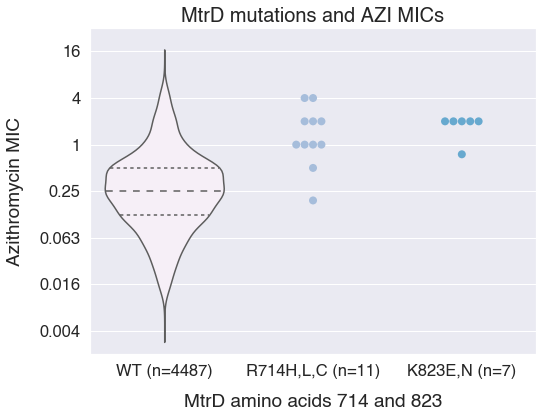

In [168]:
import numpy as np
from Bio import SeqIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

metadata = pd.read_csv('metadata/strain-table-filtered.csv', sep=',')
label714 = 'R714H,L,C (n=11)'
label823 = 'K823E,N (n=7)'
labelwt = 'WT (n=4487)'

mtrD_map = {}
for k in samples_714:
    mtrD_map[k] = label714
for k in samples_823:
    mtrD_map[k] = label823
categories = [mtrD_map[x] if x in mtrD_map else labelwt for x in metadata['GWAS_ID']]
metadata['MtrD_plot'] = categories

fig, ax = plt.subplots(figsize=(8,6))
sns.set_style('whitegrid')
sns.set(font_scale = 1.5)
sns.set_style({'font.sans-serif': 'helvetica'})

pal = {labelwt: '#f6eff7', label714: '#a6bddb', label823: '#67a9cf'}

metadata_violin = metadata[metadata['MtrD_plot'] == labelwt]
ax = sns.violinplot(data=metadata_violin[metadata_violin['AZI_LOG'] < 3], inner='quartile', saturation=0.9, cut=3, bw=.3, scale='area', x='MtrD_plot', y='AZI_LOG', order = [labelwt, label714, label823], palette = pal, jitter=True)

metadata_swarm = metadata[metadata['MtrD_plot'] != labelwt]
ax = sns.swarmplot(data=metadata_swarm[metadata_swarm['AZI_LOG'] < 3], size=8, x='MtrD_plot', y='AZI_LOG', order = [labelwt, label714, label823], palette = pal)

ax.set_yticklabels(['',0.004,0.016,0.063,0.25,1,4,16])
plt.ylim(-9,5)
ax.set_xlabel("",fontsize=20)
ax.set_ylabel("",fontsize=18)
plt.ylabel('Azithromycin MIC',  fontsize=19, labelpad=15)
plt.xlabel('MtrD amino acids 714 and 823', fontsize=19, labelpad=15)
plt.title('MtrD mutations and AZI MICs', fontsize=20)

plt.savefig('mtrD/2020-06-01_violin-plot.png', dpi=600)

### Other resistance genes

TODO: Input in linear regression model

For now, just checking what resistance genes they have; almost all have the mtr promoter mutation, and none have any of the 23S rRNA mutations. Interestingly two also have rare non-canonical RplD G70 mutations - why?

Also, some of these are mosaic penA strains, which will be interesting to report for the dual therapy angle.

In [163]:
import pandas as pd
pd.set_option('display.max_columns', 50)

covariates = pd.read_csv('metadata/combined-covariates.csv')
covariates = covariates.merge(metadata[['GWAS_ID', 'MtrD_plot']])
covariates[covariates['MtrD_plot'] != labelwt]

,GWAS_ID,Country,Reference,Year,PBP1_421,PBP2_501,PBP2_542,PBP2_551,PorB_120,PorB_121,MtrR_39,MtrR_45,GyrA_91,GyrA_95,ParC_86,ParC_87,ParC_91,RpsJ_57,FolP_229,RplD_70,mtr_promoter,mtrR,Mosaic_Mtr_BAPS,Mosaic_PenA_BAPS,rRNA23S_2059,rRNA23S_2611,MtrD_plot
61,SRR1661243,Canada,Demczuk2015,2010.0,P,A,S,P,K,N,A,G,F,G,G,R,E,M,S,G,-,full_length,11,6,0,0,"R714H,L,C (n=11)"
153,SRR2736124,Canada,Demczuk2016,2000.0,P,A,G,L,K,D,A,G,S,D,G,S,E,M,S,G,-,full_length,11,17,0,0,"K823E,N (n=7)"
185,SRR2736167,Canada,Demczuk2016,2010.0,P,A,S,P,K,N,A,G,F,G,G,R,E,M,S,G,-,full_length,11,6,0,0,"R714H,L,C (n=11)"
191,SRR2736175,Canada,Demczuk2016,2010.0,P,A,S,P,K,N,A,G,F,G,G,R,E,M,S,G,-,full_length,11,6,0,0,"R714H,L,C (n=11)"
220,SRR2736213,Canada,Demczuk2016,2011.0,P,A,G,P,K,D,A,D,F,A,G,R,E,M,S,S,-,full_length,10,17,0,0,"K823E,N (n=7)"
285,SRR2736280,Canada,Demczuk2016,2014.0,P,NaN,NaN,NaN,K,N,A,G,F,G,G,R,E,M,S,G,-,full_length,11,1,0,0,"R714H,L,C (n=11)"
286,SRR2736281,Canada,Demczuk2016,2014.0,P,T,G,P,K,D,A,G,F,G,G,S,G,M,S,G,-,full_length,11,17,0,0,"K823E,N (n=7)"
731,GCGS0502,USA,Grad2014_2016,2000.0,P,A,G,L,K,D,A,G,S,D,G,S,E,M,S,G,-,full_length,11,17,0,0,"K823E,N (n=7)"
1171,GCGS1039,USA,Grad2014_2016,2008.0,P,A,G,L,K,D,A,G,S,D,G,S,E,M,S,G,-,full_length,11,17,0,0,"R714H,L,C (n=11)"
1409,GCGS1040,USA,Grad2014_2016,2008.0,P,A,G,L,K,D,A,G,S,D,G,S,E,M,S,G,-,full_length,11,17,0,0,"R714H,L,C (n=11)"
